In [ ]:
import tensorflow as tf
from tensorflow import keras as k
import tensorflow_probability as tfp
import numpy as np
import math

import matplotlib.pyplot as plt

import asmsa

In [237]:
_default_hp = {
    'activation' : 'gelu',
    'ae_loss_fn': 'MeanSquaredError',
    'optimizer': 'Adam',
    'learning_rate' : 0.0002,
    'kde_sigma': 0.01,
    'kl_weight': 1.0,
}

@tf.function
def _KDEProb(ref,qry,sigma=1.):
    rsigma2 = -1./(2.*sigma*sigma)

    refs = tf.concat([tf.slice(tf.shape(qry),[0],[1]),tf.shape(ref)],0)
    qrys = tf.concat([tf.slice(tf.shape(ref),[0],[1]),tf.shape(qry)],0)
 
    mref = tf.broadcast_to(ref,refs)
    mqry = tf.broadcast_to(qry,qrys)
    mqry = tf.transpose(mqry,[1,0,2]) # XXX: exactly 1D shape of latent space dim

    dist2 = tf.math.reduce_sum(
        tf.math.pow(mref-mqry,2),
        axis=2
    )
    kdes = tf.exp(dist2 * rsigma2)
    kde = tf.reduce_mean(kdes,axis=1)\
        * tf.math.pow(tf.constant(2.*math.pi), tf.cast(tf.shape(ref)[1],tf.float32) * -.5)\
        / sigma
    return kde

class VAEModel(k.models.Model):
    def __init__(self,mol_shape,latent_dim=2,ae_layers=[64,32,8],
                 prior=tfp.distributions.MultivariateNormalDiag(loc=[0.,0.]),hp=_default_hp):
        
        super().__init__()
        self.hp = hp
        self.latent_dim = latent_dim
        self.prior = prior

        sample = prior.sample(10000)
        self.prior_mean = tf.reduce_mean(sample,axis=0)
        self.r_prior_std = 1.0/tf.math.reduce_std(sample-self.prior_mean,axis=0)

        inp = k.Input(shape = mol_shape)
        out = inp

        for i,n in enumerate(ae_layers):
            out = k.layers.Dense(n,activation=hp['activation'],name=f'enc_{i}')(out)
            out = k.layers.BatchNormalization(momentum=0.8,name=f'enc_bn_{i}')(out)

        out = k.layers.Dense(latent_dim,name='enc_out')(out)
        out = k.layers.BatchNormalization(momentum=0.8,name=f'enc_bn_out')(out)
        latent = out

        for i,n in enumerate(reversed(ae_layers)):
            out = k.layers.Dense(n,activation=hp['activation'],name=f'dec_{i}')(out)
            out = k.layers.BatchNormalization(momentum=0.8,name=f'dec_bn_{i}')(out)

        out = k.layers.Dense(mol_shape,activation=hp['activation'],name='dec_out')(out)

        self.enc = k.Model(inputs=inp,outputs=latent)
        self.dec = k.Model(inputs=latent,outputs=out)

    def compile(self,optimizer=None,lossfn=k.losses.MeanSquaredError()):
        if optimizer is None:
            optimizer = self.hp['optimizer']

        if isinstance(optimizer,str):
            optimizer = k.optimizers.legacy.__dict__[optimizer]

        super().compile(optimizer = optimizer(learning_rate=self.hp['learning_rate']))
        self.ae_weights = self.enc.trainable_weights + self.dec.trainable_weights
        self.lossfn = lossfn
   
    @tf.function
    def train_step(self,batch):
        prob_shift = 1e-15
        
        if isinstance(batch,tuple):
            batch = batch[0]

        with tf.GradientTape() as aetape:
            out = self.dec(self.enc(batch,training=True),training=True)
            loss = self.lossfn(batch,out)

        ae_grad = aetape.gradient(loss,self.ae_weights)
        self.optimizer.apply_gradients(zip(ae_grad,self.ae_weights))

        prior_sample = (self.prior.sample(tf.shape(batch)[0]) - self.prior_mean) * self.r_prior_std
        prior_mean = tf.reduce_mean(prior_sample,axis=0)
        with tf.GradientTape() as kltape:
            latent = self.enc(batch,training=True)
            latent_mean = tf.reduce_mean(latent,axis=0)
            latent_prior = latent_mean - prior_mean
            mean_dist2 = tf.reduce_sum(latent_prior * latent_prior)
#            tf.print(latent_mean, prior_mean, mean_dist2)
            
            both = tf.concat([latent,prior_sample],axis=0)
            latent_prob = _KDEProb(latent,both,self.hp['kde_sigma']) + prob_shift
            prior_prob = self.prior.prob(both) + prob_shift
            kl = tf.reduce_mean(tf.math.log(latent_prob / prior_prob))
            kl_loss = kl * kl * self.hp['kl_weight'] + mean_dist2

        kl_grad = kltape.gradient(kl_loss,self.enc.trainable_weights)
        self.optimizer.apply_gradients(zip(kl_grad,self.enc.trainable_weights))

#        tf.print('\nstep: ',kl)

        return { 'AE loss' : loss, 'KL' : kl, 'mean distance' : mean_dist2}


In [ ]:
conf='alaninedipeptide_H.pdb'
gro='aladip_H.gro'
topol='aladip_H.top'
index=None
traj='alaninedipeptide_reduced.xtc'

In [ ]:
import mdtraj as md
import nglview as nv

In [ ]:
tr = md.load(traj,top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like Ala-Ala, where superposing on CAs fails
idx=tr[0].top.select("element != H")

tr.superpose(tr[0],atom_indices=idx)
nv.show_mdtraj(tr)

In [ ]:
# gmx pdb2gmx -f alaninedipeptide_H.pdb -o aladip_H.gro -p aladip_H.top -n aladip_H.ndx -water tip3p -ff amber99 -ignh

In [ ]:
np.random.shuffle(tr.xyz)

In [ ]:
train = .7
validation = .15
test = .15

assert train + validation + test == .9999999999999999 or 1

tr_i = len(tr) * train
X_train = tr.slice(slice(0,int(tr_i)))

va_i = len(tr) * validation
X_validate = tr.slice(slice(int(tr_i),int(tr_i)+int(va_i)))

te_i = len(tr) * test
X_test = tr.slice(slice(int(tr_i)+int(va_i),len(tr)))

X_train.xyz.shape, X_validate.xyz.shape, X_test.xyz.shape

In [ ]:
X_train.save_xtc('train.xtc')
X_validate.save_xtc('validate.xtc')
X_test.save_xtc('test.xtc')

In [ ]:
trajs = [X_train, X_validate, X_test]
geoms = []

for i in range(len(trajs)):
    geoms.append(np.moveaxis(trajs[i].xyz,0,-1))
    print(geoms[i].shape)

In [ ]:
tf.data.Dataset.from_tensor_slices(geoms[0]).save('datasets/geoms/train')
tf.data.Dataset.from_tensor_slices(geoms[1]).save('datasets/geoms/validate')
tf.data.Dataset.from_tensor_slices(geoms[2]).save('datasets/geoms/test')

In [ ]:
mols = []
for i in range(len(geoms)):
    sparse_dists = asmsa.NBDistancesDense(geoms[i].shape[0])
    mols.append(asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists]))


In [ ]:
intcoords = []
for i in range(len(mols)):
    intcoords.append(mols[i].intcoord(geoms[i]).T)
    print(intcoords[i].shape)

In [ ]:
tf.data.Dataset.from_tensor_slices(intcoords[0]).save('datasets/intcoords/train')
tf.data.Dataset.from_tensor_slices(intcoords[1]).save('datasets/intcoords/validate')
tf.data.Dataset.from_tensor_slices(intcoords[2]).save('datasets/intcoords/test')

In [ ]:
[train,validate,test] = intcoords

In [ ]:
# normalize training set
train_mean = np.mean(train,axis=0)
train -= train_mean
train_scale = np.std(train,axis=0)
train /= train_scale

In [ ]:
# normalize test and validation sets
test -= train_mean
test /= train_scale
validate -= train_mean
validate /= train_scale

In [ ]:
np.max(np.mean(test,axis=0)),np.min(np.mean(test,axis=0))

In [280]:
hp = _default_hp.copy()
# normal & uniform, 1024
train_batch = tf.data.Dataset.from_tensor_slices(train).batch(1024,drop_remainder=True)

# image
train_batch = tf.data.Dataset.from_tensor_slices(train).batch(128,drop_remainder=True)


In [ ]:
class _Uniform2d:
    def __init__(self,low=-1.,high=1):
        self.low = tf.constant(low,tf.float32)
        self.high = tf.constant(high,tf.float32)
        self.density = 1./(self.high-self.low)**2
        self.uniform = tfp.distributions.Uniform(low=low,high=high)

    def prob(self,samples):
        out = tf.broadcast_to(self.density,shape=[tf.shape(samples)[0]])
        out *= tf.cast(samples[:,0] >= self.low,tf.float32)
        out *= tf.cast(samples[:,0] <= self.high,tf.float32)
        out *= tf.cast(samples[:,1] >= self.low,tf.float32)
        out *= tf.cast(samples[:,1] <= self.high,tf.float32)
        return out

    def sample(self,n):
        return self.uniform.sample([n,2])
        
        

In [ ]:
import PIL

class _ImageDist:
    def __init__(self,image):
        img = np.array(PIL.Image.open(image),dtype=np.float64)
        img /= 255.
        if len(img.shape) == 3:
            img = np.sum(img,axis=2)

        assert len(img.shape) == 2
        img /= np.sum(img)
        
        
        self.shape = img.shape
        self.flat = tf.convert_to_tensor(np.cumsum(img.flatten()).astype(np.float32))
        self.img = tf.constant(img * img.shape[0]*img.shape[1], tf.float32)

    def sample(self,n):
        u = tf.random.uniform(shape=[n])
        b = tf.broadcast_to(self.flat,u.shape[:-1]+self.flat.shape)
        flati = tf.searchsorted(b,u)
        x = tf.cast(flati % self.shape[1],tf.float32)
        x += tf.random.uniform(x.shape)
        y = tf.cast(flati // self.shape[1],tf.float32)
        y += tf.random.uniform(y.shape)
        x /= self.shape[1]
        y = 1. - y/self.shape[0]
        return tf.stack([x,y],axis=-1)

    def prob(self,samples):
        isamples = tf.cast(tf.stack([1.-samples[:,1],samples[:,0]],axis=1) * self.shape,tf.int32)
        return tf.gather_nd(self.img,isamples)

In [281]:
prior=tfp.distributions.MultivariateNormalDiag(loc=[0.,0.])
prior = _Uniform2d(0,1)
prior = _ImageDist('mushroom_bw.png')
mod=VAEModel(train.shape[1], 
            ae_layers=[16,8],
            prior=prior,
            hp=hp)
mod.compile()

In [282]:
mod.fit(train_batch,epochs=10)

Epoch 1/10
546/546 [==============================] - 4s 5ms/step - AE loss: 0.9593 - KL: 15.5991 - mean distance: 0.0148
Epoch 2/10
546/546 [==============================] - 3s 5ms/step - AE loss: 0.9186 - KL: 15.7560 - mean distance: 0.0166
Epoch 3/10
546/546 [==============================] - 3s 5ms/step - AE loss: 0.9031 - KL: 15.9973 - mean distance: 0.0162
Epoch 4/10
546/546 [==============================] - 3s 5ms/step - AE loss: 0.8958 - KL: 16.0964 - mean distance: 0.0159
Epoch 5/10
546/546 [==============================] - 3s 5ms/step - AE loss: 0.8916 - KL: 16.1124 - mean distance: 0.0154
Epoch 6/10
546/546 [==============================] - 3s 5ms/step - AE loss: 0.8904 - KL: 16.0752 - mean distance: 0.0156
Epoch 7/10
546/546 [==============================] - 3s 5ms/step - AE loss: 0.8913 - KL: 16.0287 - mean distance: 0.0188
Epoch 8/10
546/546 [==============================] - 3s 5ms/step - AE loss: 0.8890 - KL: 16.0240 - mean distance: 0.0180
Epoch 9/10
546/546 [====

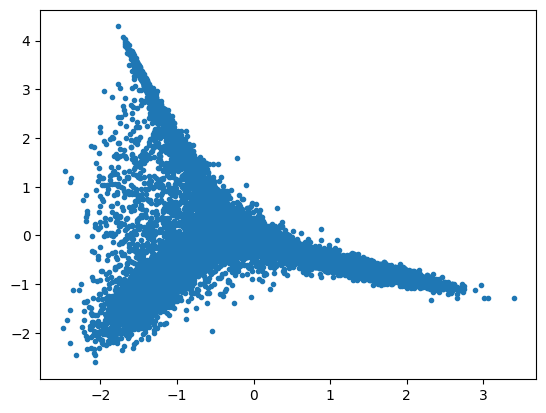

In [283]:
lows = mod.enc(test,training=False).numpy()

plt.scatter(lows[:,0],lows[:,1],marker='.')
plt.show()

In [255]:
prior_sample = mod.prior.sample(1024)
prior_mean = tf.reduce_mean(prior_sample,axis=0)


In [256]:
latent=lows[:1024]
latent_mean = tf.reduce_mean(latent,axis=0)
latent_prior = latent_mean - prior_mean
mean_dist2 = tf.reduce_sum(latent_prior * latent_prior)
mean_dist2

<tf.Tensor: shape=(), dtype=float32, numpy=0.004417157>

In [257]:
latent_mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.05063147, -0.02756877], dtype=float32)>

In [258]:
mod.enc.layers[6].moving_mean

<tf.Variable 'enc_bn_out/moving_mean:0' shape=(2,) dtype=float32, numpy=array([-0.01357053,  0.03804791], dtype=float32)>

In [259]:
np.mean(lows[:1024],axis=0)

array([ 0.05063149, -0.02756878], dtype=float32)

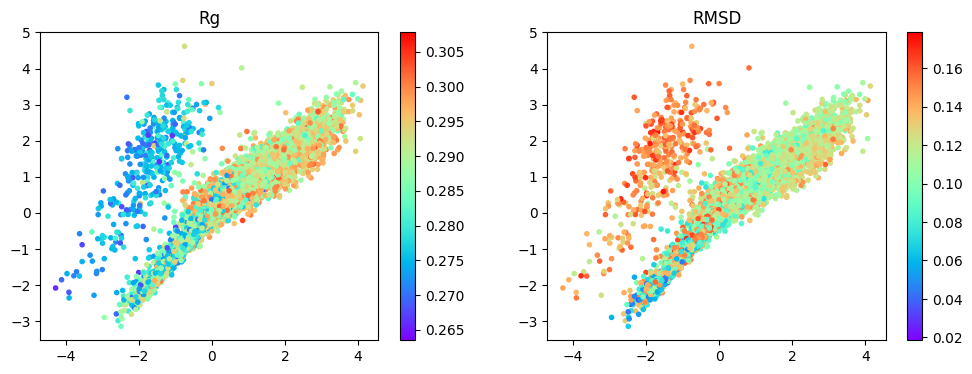

In [272]:
rg = md.compute_rg(X_test)
base = md.load(conf)
rmsd = md.rmsd(X_test,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

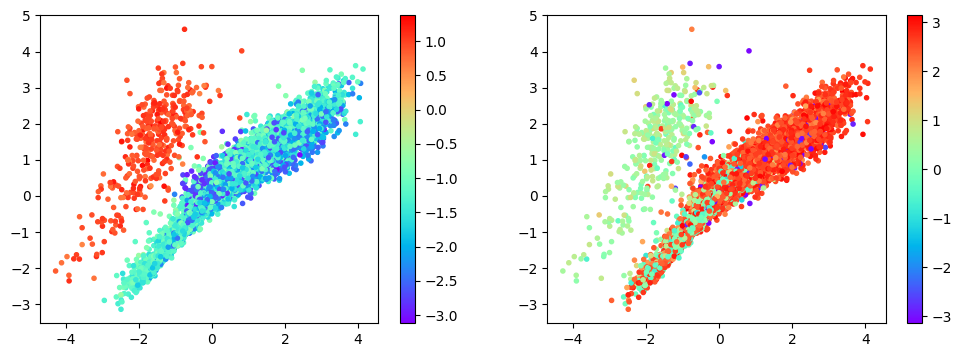

In [273]:
plt.figure(figsize=(12,4))
plt.subplot(121)
dih=md.compute_dihedrals(X_test,np.array([[4,6,8,14],[6,8,14,16]]))
plt.scatter(lows[:,0],lows[:,1],marker='.',c=dih[:,0],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=dih[:,1],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.show()

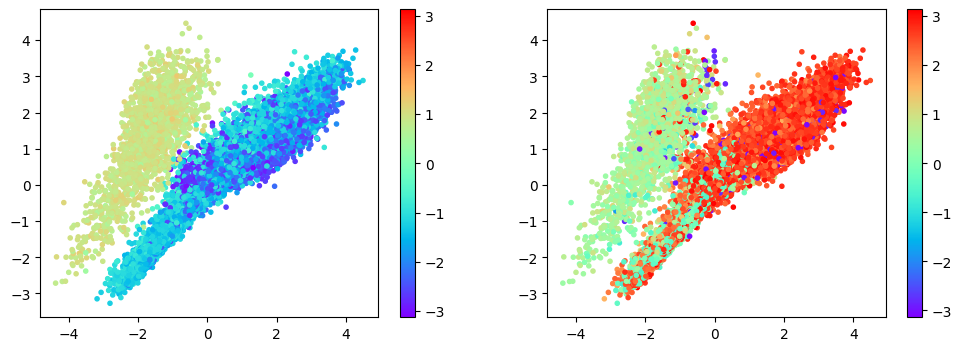

In [274]:
low_train = mod.enc(train).numpy()
plt.figure(figsize=(12,4))
plt.subplot(121)
dih=md.compute_dihedrals(X_train,np.array([[4,6,8,14],[6,8,14,16]]))
plt.scatter(low_train[:,0],low_train[:,1],marker='.',c=dih[:,0],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.subplot(122)
plt.scatter(low_train[:,0],low_train[:,1],marker='.',c=dih[:,1],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.show()

In [ ]:
out_test = mod.dec(mod.enc(test))
np.mean(k.metrics.mean_squared_error(test,out_test).numpy())

In [ ]:
out_train = mod.dec(mod.enc(train))
np.mean(k.metrics.mean_squared_error(train,out_train).numpy())

In [ ]:
s = prior.sample(10000)
tf.reduce_mean(s,axis=0)

In [ ]:
tf.math.reduce_std(s,axis=0)

In [268]:
mod.prior_mean,mod.r_prior_std

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5028173 , 0.50453186], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.498539 , 3.4539225], dtype=float32)>)